In [2]:
!pip install earthpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 27.8 MB/s 
     |████████████████████████████████| 19.3 MB 81.1 MB/s 
     |████████████████████████████████| 1.0 MB 41.1 MB/s 
     |████████████████████████████████| 6.3 MB 43.4 MB/s 
     |████████████████████████████████| 16.7 MB 60.6 MB/s 


In [3]:
import earthpy.plot as ep
import earthpy as et
import earthpy.spatial as es
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the .mat file with loadmat

In [4]:
#taken by the 224 band AVIRIS with 20 bands removed for water absorption

data = loadmat('/content/drive/My Drive/DAT690/Salinas_corrected.mat')['salinas_corrected']

gt = loadmat('/content/drive/My Drive/DAT690/Salinas_gt.mat')['salinas_gt']

print(f'Data Shape: {data.shape}\nNumber of Bands: {data.shape[-1]}')

print(f'Groundtruthing Shape: {gt.shape}')

Data Shape: (512, 217, 204)
Number of Bands: 204
Groundtruthing Shape: (512, 217)


In [5]:
df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))

In [6]:
df

,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,200,201,202,203
0,290,381,585,1041,1316,1397,1319,1462,1643,1683,...,104,96,109,93,54,79,54,36,11,17
1,290,381,519,1041,1316,1352,1319,1462,1643,1683,...,111,94,111,96,56,83,56,36,11,15
2,290,381,585,1041,1286,1352,1300,1412,1614,1644,...,106,88,107,89,54,81,54,30,11,11
3,290,381,585,999,1316,1374,1280,1380,1584,1631,...,100,86,105,85,56,75,50,30,11,19
4,219,381,585,999,1286,1352,1261,1396,1555,1618,...,96,83,105,83,48,75,50,24,9,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111099,376,405,608,1043,1382,1446,1376,1526,1719,1760,...,141,121,150,124,72,112,76,46,17,27
111100,305,489,608,1086,1353,1446,1357,1510,1704,1760,...,138,126,144,122,76,106,74,40,13,21
111101,447,405,674,1128,1382,1446,1357,1493,1690,1760,...,141,117,146,120,72,108,76,42,11,23
111102,447,405,674,1086,1382,1424,1357,1493,1704,1734,...,136,123,144,122,80,110,78,42,17,27


In [7]:
Class = pd.DataFrame(gt.ravel())

In [8]:
Class

,0
0,0
1,0
2,0
3,0
4,0
...,...
111099,0
111100,0
111101,0
111102,0


In [9]:
df["Class"] = Class

In [10]:
df

,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,200,201,202,203,Class
0,290,381,585,1041,1316,1397,1319,1462,1643,1683,...,96,109,93,54,79,54,36,11,17,0
1,290,381,519,1041,1316,1352,1319,1462,1643,1683,...,94,111,96,56,83,56,36,11,15,0
2,290,381,585,1041,1286,1352,1300,1412,1614,1644,...,88,107,89,54,81,54,30,11,11,0
3,290,381,585,999,1316,1374,1280,1380,1584,1631,...,86,105,85,56,75,50,30,11,19,0
4,219,381,585,999,1286,1352,1261,1396,1555,1618,...,83,105,83,48,75,50,24,9,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111099,376,405,608,1043,1382,1446,1376,1526,1719,1760,...,121,150,124,72,112,76,46,17,27,0
111100,305,489,608,1086,1353,1446,1357,1510,1704,1760,...,126,144,122,76,106,74,40,13,21,0
111101,447,405,674,1128,1382,1446,1357,1493,1690,1760,...,117,146,120,72,108,76,42,11,23,0
111102,447,405,674,1086,1382,1424,1357,1493,1704,1734,...,123,144,122,80,110,78,42,17,27,0


In [11]:
512*217

111104

## Data Exploration

In [12]:
#shift the axis so that the bands are at the beginning and it only displays one at a time

mdata = np.moveaxis(data, -1, 0)

print(f'Data Shape: {mdata.shape}')

Data Shape: (204, 512, 217)


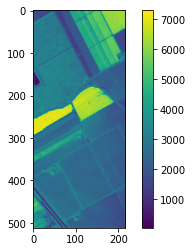

In [13]:
plt.figure()
plt.imshow(mdata[50])
plt.colorbar()

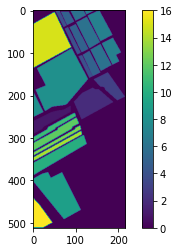

In [14]:
#ground truthed image so this is our y

plt.figure()
plt.imshow(gt)
plt.colorbar()

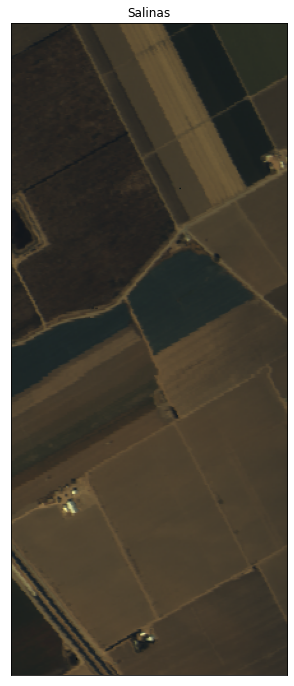

In [15]:
# Create figure with one plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot red, green, and blue bands, respectively
ep.plot_rgb(mdata, rgb=(25, 15, 6), ax=ax, title="Salinas")
plt.show()

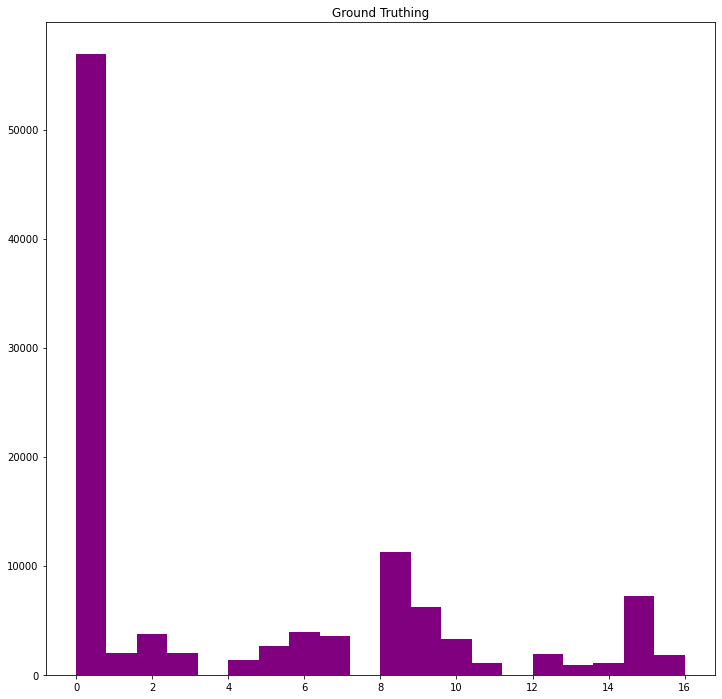

In [16]:
ep.hist(gt, title="Ground Truthing")
plt.show()

In [17]:
gt_frame = pd.DataFrame(gt)

In [18]:
gt_frame.head()

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,216
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


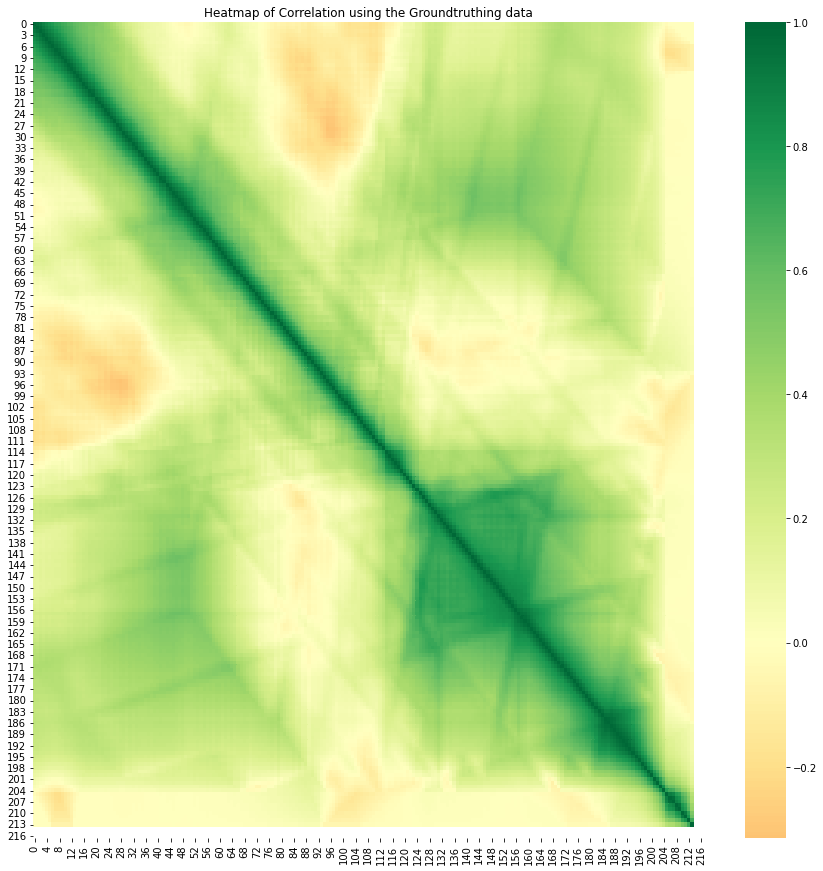

In [19]:
plt.figure(figsize=(15,15))
plt.title("Heatmap of Correlation using the Groundtruthing data")
p=sns.heatmap(gt_frame.corr(), annot=False,cmap='RdYlGn',center=0) 

## Splitting the data for training and testing

In [20]:
new_df = df[df["Class"] != 0]

X = new_df.loc[:, new_df.columns != 'Class']
y = new_df["Class"].astype("category")

X.shape, y.shape

((54129, 204), (54129,))

In [21]:
y

305        6
306        6
307        6
308        6
309        6
          ..
110689    16
110690    16
110691    16
110692    16
110693    16
Name: Class, Length: 54129, dtype: category
Categories (16, uint64): [1, 2, 3, 4, ..., 13, 14, 15, 16]

In [22]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [23]:
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

input_shape = X_train.shape[1]

X_valid.shape, y_valid.shape, input_shape

((5000, 204), (5000,), 204)

In [24]:
input_shape

204

In [25]:
n_outputs = y_train.shape[-1]

n_outputs  

38303

## Building and Training the Model

In [26]:
model = keras.models.Sequential([
                                 keras.layers.Conv1D(256, 3, activation = "selu", kernel_initializer = "lecun_normal", input_shape = [input_shape, 1], padding = "same"),
                                 keras.layers.Conv1D(256, 3, activation = "selu", kernel_initializer = "lecun_normal", padding = "same"),
                                 keras.layers.Conv1D(256, 3, activation = "selu", kernel_initializer = "lecun_normal", padding = "same"),

                                 keras.layers.MaxPool1D(2),
                                 keras.layers.BatchNormalization(),

                                 keras.layers.Conv1D(128, 3, activation = "selu", kernel_initializer = "lecun_normal", padding = "same"),
                                 keras.layers.Conv1D(128, 3, activation = "selu", kernel_initializer = "lecun_normal", padding = "same"),
                                 keras.layers.Conv1D(128, 3, activation = "selu", kernel_initializer = "lecun_normal", padding = "same"),

                                 keras.layers.MaxPool1D(2),
                                 keras.layers.BatchNormalization(),

                                 keras.layers.Conv1D(64, 3, activation = "selu", kernel_initializer = "lecun_normal", padding = "same"),
                                 keras.layers.Conv1D(64, 3, activation = "selu", kernel_initializer = "lecun_normal", padding = "same"),
                                 keras.layers.Conv1D(64, 3, activation = "selu", kernel_initializer = "lecun_normal", padding = "same"),

                                 keras.layers.Flatten(),
                                 keras.layers.Dense(128, activation = "selu", kernel_initializer = "lecun_normal"),
                                 keras.layers.Dropout(0.4),
                                 keras.layers.Dense(64, activation = "selu", kernel_initializer = "lecun_normal"),
                                 keras.layers.Dropout(0.4),
                                 keras.layers.Dense(17, activation="softmax")

])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 204, 256)          1024      
                                                                 
 conv1d_1 (Conv1D)           (None, 204, 256)          196864    
                                                                 
 conv1d_2 (Conv1D)           (None, 204, 256)          196864    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 102, 256)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 102, 256)         1024      
 ormalization)                                                   
                                                                 
 conv1d_3 (Conv1D)           (None, 102, 128)          9

In [28]:
early_stop = keras.callbacks.EarlyStopping(patience=20, restore_best_weights = True)
checkpoint = keras.callbacks.ModelCheckpoint("LandUse_CNN.h5")

In [29]:
model.compile(optimizer="Nadam", loss="sparse_categorical_crossentropy",metrics = ["accuracy"])

In [30]:
X_train.shape

(38303, 204)

In [31]:
history = model.fit(X_train, y_train, epochs=20, callbacks=[early_stop, checkpoint],
          validation_data=(X_valid,y_valid))

Epoch 1/20
1197/1197 [==============================] - 549s 451ms/step - loss: 0.9950 - accuracy: 0.6667 - val_loss: 0.4485 - val_accuracy: 0.7906
Epoch 2/20
1197/1197 [==============================] - 552s 461ms/step - loss: 0.5505 - accuracy: 0.7775 - val_loss: 0.3733 - val_accuracy: 0.8252
Epoch 3/20
1197/1197 [==============================] - 550s 459ms/step - loss: 0.4916 - accuracy: 0.7963 - val_loss: 0.3689 - val_accuracy: 0.8388
Epoch 4/20
1197/1197 [==============================] - 535s 447ms/step - loss: 0.4588 - accuracy: 0.8088 - val_loss: 0.3729 - val_accuracy: 0.8242
Epoch 5/20
1197/1197 [==============================] - 537s 448ms/step - loss: 0.4134 - accuracy: 0.8247 - val_loss: 0.3193 - val_accuracy: 0.8464
Epoch 6/20
1197/1197 [==============================] - 533s 446ms/step - loss: 0.3929 - accuracy: 0.8349 - val_loss: 0.5113 - val_accuracy: 0.7956
Epoch 7/20
1197/1197 [==============================] - 534s 446ms/step - loss: 0.3648 - accuracy: 0.8454 - val_

In [38]:
model.save("LandUse_CNN.h5")

## Model Evaluation and Results

In [88]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn import metrics

In [ ]:
model = keras.models.load_model("LandUse_CNN.h5")

In [33]:
model.evaluate(X_test, y_test)

339/339 [==============================] - 43s 127ms/step - loss: 0.2013 - accuracy: 0.9109


[0.2013166844844818, 0.9108627438545227]

In [53]:
y_pred = np.argmax(model.predict(X_test), axis=1)

In [58]:
y_pred = pd.DataFrame(y_pred.ravel())

In [61]:
y_test = pd.DataFrame(y_test)

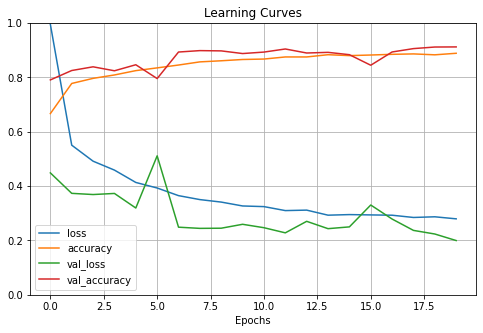

In [37]:
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("Learning Curves")
plt.xlabel("Epochs")
plt.show()

Accuracy: 0.9108627378533161


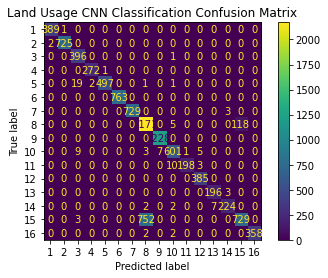

<Figure size 1080x1080 with 0 Axes>

In [89]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title('Land Usage CNN Classification Confusion Matrix')
plt.figure(figsize = (15,15))
plt.show()

In [87]:
precision = precision_score(y_test, y_pred, average = None)
recall = recall_score(y_test, y_pred, average = None)
f1Score = f1_score(y_test, y_pred, average = None)

print(f"Precision Scores: {precision}")
print(f"Recall Scores: {recall}")
print(f"f1 Scores: {f1Score}")

Precision Scores: [0.99488491 0.99862259 0.92740047 0.99270073 0.99799197 1.
 1.         0.74070283 0.99433198 0.96623794 0.99497487 0.97964377
 0.96551724 0.97391304 0.86068477 1.        ]
Recall Scores: [0.9974359  0.99724897 0.99748111 0.996337   0.95576923 1.
 0.99590164 0.94638187 1.         0.9600639  0.93838863 1.
 0.98492462 0.95319149 0.49123989 0.98895028]
f1 Scores: [0.99615877 0.99793531 0.96116505 0.99451554 0.97642436 1.
 0.99794661 0.83100478 0.99715794 0.96314103 0.96585366 0.98971722
 0.97512438 0.96344086 0.62548263 0.99444444]
